Se va a hacer un estudio de la regresión lineal y dos formas de entrenar el modelo:

- Usando una forma cerrada que computa directo los parámetros que mejor ajusten el modelo.
- Usando descenso de gradiente que ajusta los parámetros del modelo para minimizar la función de costo, eventualmente llegando a los mismos parámetros de la opción anterior.

## Regresión lineal

Se tiene que la regresión lineal es:

$$
\hat{y} = \beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_nx_n
$$

La manera más común de medir el rendimiento de este modelo es la raiz media del error cuadrado (RMSE), tenemos que encontrar los valores de $\beta$ que minimicen el error cuadrado medio (MSE)

$$
MSE(X, h_{\beta} = \frac{1}{m}\sum(\beta^Tx^{i} - y{(i)})^2
$$

###  La ecuación normal

Para encontrar el valor de $\beta$ que minimiza el MSE eciste un solución de forma cerrada, que da el resultado directo, esta se llama *la ecuación normal*

$$
\hat{\beta} = (X^TX)^{-1}X^Ty
$$

Vamos a generar datos para probar la ecuación:

In [1]:
import numpy as np

np.random.seed(42)
m = 100 # número de instancias
X = 2 * np.random.rand(m, 1) # vector columna
y = 4 + 3 * X + np.random.randn(m, 1) # vector columna

Text(0, 0.5, 'y')

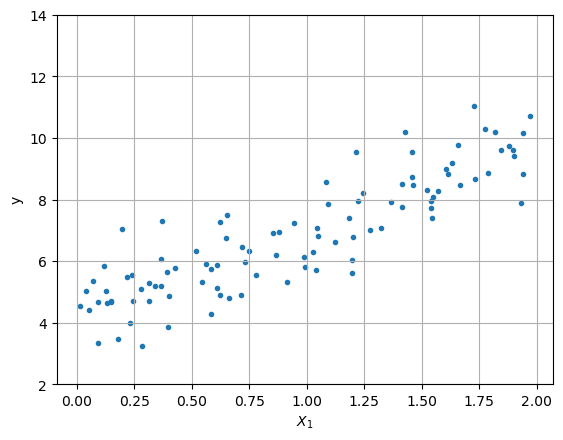

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(X, y, marker = '.')
plt.grid('True')
plt.ylim((2, 14))
plt.xlabel(r'$X_1$')
plt.ylabel('y')

Ahora computemos $\hat{\beta}$ usando la ecuación normal

In [3]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X) # agregar la columna de 1, para el intercepto
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
theta_best

array([[4.21509616],
       [2.77011339]])

Un valor bastante parecido, ya que el intercepto original es 4 y la pendiente es 3, ahora podemos hacer predicciones con los parámetros encontrados

In [4]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)
y_predict = X_new_b @ theta_best
y_predict

array([[4.21509616],
       [9.75532293]])

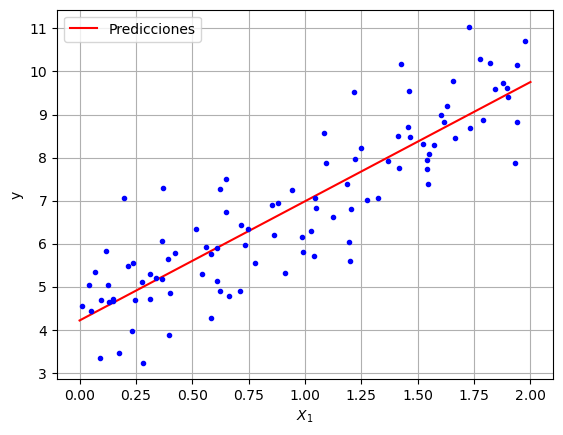

In [5]:
plt.plot(X_new, y_predict, 'r-', label = 'Predicciones')
plt.plot(X, y, 'b.')
plt.grid('True')
plt.legend(loc = 'best')
plt.xlabel(r'$X_1$')
plt.ylabel('y');

Ahora haciendo la regresión lineal con Scikit learn

In [6]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [7]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

La clase de LinearRegression viene de least squares, el cual se puede llamar directo

In [8]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond = 1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

Esta función computa $\hat{\theta} = X^+y$, donde $X^+$ es la pseudo inversa de X (la inversa de Moore - Penrose), se puede calcular directamente

In [9]:
np.linalg.pinv(X_b) @ y

array([[4.21509616],
       [2.77011339]])

La pseudo inversa se calcula usando una factorización de matrices llamada *singular value decomposition (SVD)*.

### Complejidad computacional

Al tener que computar la inversa de matrices tan grandes la complejidad computacional es de $O(n^{2.4}), O(n^3)$, la implementación SVD de scikit es de $0(n^2)$ si doblas el número de variables se multiplica el tiempo de computación por aproximadamente 4.

### Descenso de gradiente

Este es un algoritmo de optimización, ajusta parámetros iterativamente minimizando una función de costo.

Mide el gradiente local en la función de error respecto al vector de parámetros $\beta$ y va en la dirección de descenso del gradiente, una vez el gradiente es cero se alcanzó el minimo!

En la practica se empieza con valores de $\beta$ aleatorios y se mejora gradualmente hasta que converge al minimo. 

El paso de aprendizaje es proporcional a la pendiente de la función de costo, un parámetro importante en el descenso de gradiente es el tamaño del paso determinado por el hiperparámetro: *la tasa de aprendizaje (learning rate)*.

Hay varias dificultades de este algoritmo, si la tasa de aprendizaje es muy pequeña se va a demorar mucho en encontrar el minimo, si es muy grande puede converger a otro valor diferente al minimo, si la función de costo tiene una forma irregular pueden converger a minimos locales y no globales o nunca encontrar un minimo, la facilidad del MSE para una regresión linear es que es una función convexa, con lo cual solo hay un minimo global.

Al usar descenso de gradiente hay que estar seguros que todas las variables tienen la misma escala o va a tomar mucho tiempo para converger

### Descenso de gradiente por lotes

Para implementar descenso de gradiente hay que computar el gradiente de la función de costo respecto a cada parámetro $\beta_j$, esto se hace con derivadas parciales:

$$
\frac{\delta}{\delta \beta_j}MSE(\beta) = \frac{2}{m}\sum(\beta^Tx^{(i)} - y^{(i)})x_j^{(i)}
$$

En vez de hacerla una por una tenemos el vector gradiente $\nabla_{\beta}MSE(\beta)$ que contiene todas las derivadas parciales de la función de costo

$$
\nabla_{\beta}MSE(\beta) = 
\begin{pmatrix} 
\frac{\delta}{\delta \beta_0}MSE(\beta) \\
\frac{\delta}{\delta \beta_1}MSE(\beta) \\
\vdots \\
\frac{\delta}{\delta \beta_n}MSE(\beta)
\end{pmatrix} =
\frac{2}{m}X^T(X\beta-y)
$$

Para este algoritmo se necesita calcular sobre todo el conjunto de entrenamiento en cada paso del gradiente, por eso se llama descenso de gradiente por lotes, usa el lote completo de entrenamiento en cada paso, por lo tanto puede llegar a ser lento con muchos datos per escala bien con muchas variales, mucho más rápido que la ecuación normal o la descomposición SVD.

Una vez que se tenga el vector gradiente que apunta hacia arriba, solo hay que ir hacia el lado contrario, restar $\nabla_{\beta}MSE(\beta)$ de $\beta$, aquí entra en juego la tasa de aprendizaje $\eta$, multiplicar el gradiente por $\eta$ para determinar el tamaño del paso hacia abajo.

$$
\theta^{(proximo paso)} = \theta - \eta\nabla_{\beta}MSE(\beta)
$$

Ahora vamos a implementarlo.

In [10]:
eta = 0.1
n_epochs = 1000 # cada iteración en el conjunto de entrenamiento se llama epoch
m = len(X_b)

np.random.seed(42)
theta = np.random.randn(2, 1) # parámetro inicializado aleatoriamente

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients
    
theta

array([[4.21509616],
       [2.77011339]])

Veamos la diferencia en tasa de aprendizaje

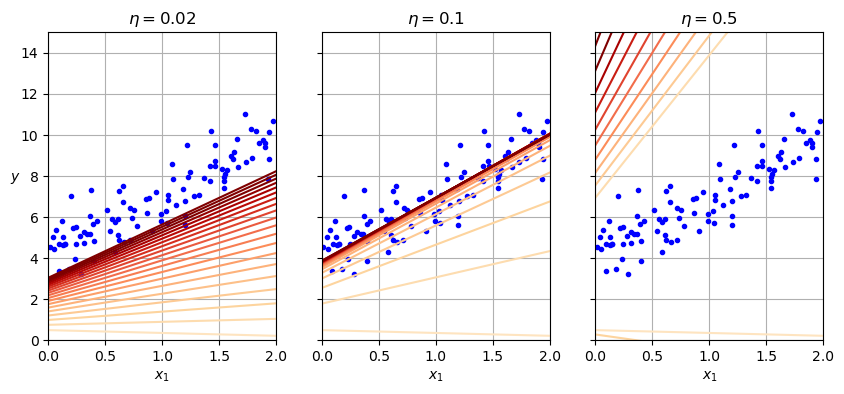

In [11]:
import matplotlib as mpl

def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")
    return theta_path

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta=0.5)
plt.show()

Con una tasa muy pequeña empieza tener cambios muy pequeños y se demora mucho en converger a la solución, con 0.1 vemos que converge rapidamente a la solución, con 0.5 muy grande vemos que diverge, por lo tanto nunca va a llegar a la solución.

Para encontrar una buena tasa de parendizaje se puede hacer una busqueda de cuadricula, pero es mejor limitar los epochs para que la busqueda elimine modelos que se demoren mucho en converger.

Para establecer el numero de epochs la solución es establecer un número muy grande pero para el algoritmo cuando el vector gradiente se vuelva muy pequeño, cuando la norma se vuelva mas pequeña que un numero $\epsilon$ llamado tolerancia.

### Descenso de gradiente estocástico

El problema con el descenso de gradiene por lotes es que usa todo el conjunto de entrenamiento en cada paso, al contrario, el descenso de gradiente estocástico escoge una instancia aleatoria y computa el gradiente en esa instancia.

Debido a su naturaleza aleatoria este algoritmo es mucho menos regual que por lotes, en vez de decrecer hasta encontrar el minimo va a saltar de un lado a otro decreciendo en promedio, se acerca al minimo y seguirá moviendose, una vez termina los parámetros van a ser buenos pero no óptimos.

Cuando la función de costo es irregular esto puede ayudar al algoritmo a encontrar un mejor minimo al de por lotes.

Aleatoriedad es bueno ya que ayuda a salir de los minimos locales pero no podemos asgurar un minimo global, para esto se puede reducir gradulamente la tasa de aprendizaje. Empezar con una tasa grande que ayude a salir del minimo local e ir reduciendola ayudando al algoritmo a estar en el minimo global, la función que determina la tasa de aprendizaje se llama la agenda de aprendizaje, si se reduce muy rapido se puede quedar en un minimo local, si se reduce muy rápido se puede terminar en una solución subóptima, así se aplica,

In [12]:
n_epochs = 50
t0, t1 = 5, 50 # hiperparámetros de la agenda de aprendizaje

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1) # Comenza aleatoriamente

for epoch in range(n_epochs):
    for iteration in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi) # para SGD, no dividir por m
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients

In [13]:
theta

array([[4.21076011],
       [2.74856079]])

Iteramos por ronda m iteraciones, cada ronda es llamada epoch, mientras que por lotes iteró 1000 veces por todo el conjunto, este código sólo itera por el conjunto de entrenamiento 50 veces y obtiene una solución parecida.

Para hacer regresión lineal usando GD estocástico con scikit learn se puede hacer así:

En SGDRegressor la función de costo default es el MSE, hacemos 1000 epochs o hasta que la baja de perdida sea menor a 1e-5 durante 100 epochs, empieza con una tasa de aprendizaje de 0.01 usando la agenda de aprendizaje por default, y sin regularización (penalty = None)

In [14]:
from sklearn.linear_model import SGDRegressor 

sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-5, penalty = None, eta0 = 0.01,
                      n_iter_no_change = 100, random_state = 42)
sgd_reg.fit(X, y.ravel()) # ravel porque fit espera 1D variables respuesta

SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

In [15]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

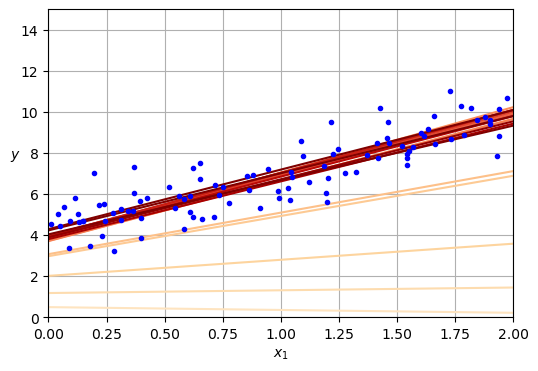

In [16]:
theta_path_sgd = []  # extra code – we need to store the path of theta in the
                     #              parameter space to plot the next figure
    
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

n_shown = 20  # extra code – just needed to generate the figure below
plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting

for epoch in range(n_epochs):
    for iteration in range(m):

        # extra code – these 4 lines are used to generate the figure
        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color=color)

        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi)  # for SGD, do not divide by m
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)  # extra code – to generate the figure

# extra code – this section beautifies and saves Figure 4–10
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

### Descenso de gradiente de mini lote

En cada paso en vez de computar el gradiente en el conjunto de entrenamiento o en una sola instancia, mini lote GD computa el gradiente en varios conjuntos aleatorios llamados mini lotes, la ventaja es que se puede obtener mejor rendimiento usando la optimización de operaciones matriciales, este algoritmo se acerca un poco mas al minimo que el estocástico pero puede encontrar más dificil escapar de un minimo local, no hay casi diferencia en los resultados de cada algoritmo pero por mini lotes y estocástico se van a demorar mucho menos en correr.

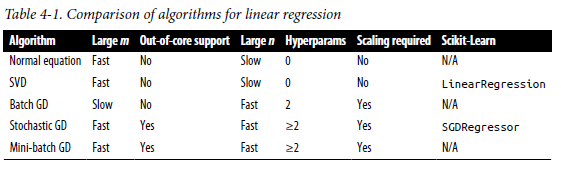

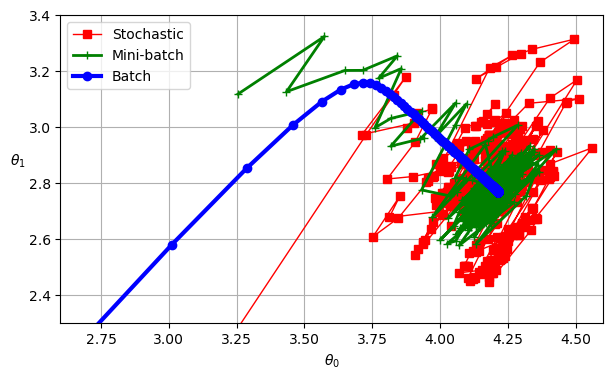

In [17]:
from math import ceil

n_epochs = 50
minibatch_size = 20
n_batches_per_epoch = ceil(m / minibatch_size)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

t0, t1 = 200, 1000  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta_path_mgd = []
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for iteration in range(0, n_batches_per_epoch):
        idx = iteration * minibatch_size
        xi = X_b_shuffled[idx : idx + minibatch_size]
        yi = y_shuffled[idx : idx + minibatch_size]
        gradients = 2 / minibatch_size * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(iteration)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7, 4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1,
         label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2,
         label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3,
         label="Batch")
plt.legend(loc="upper left")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$   ", rotation=0)
plt.axis([2.6, 4.6, 2.3, 3.4])
plt.grid()
plt.show()

### Regresión polinómica

Si nuestros datos son más complejos que una linea recta, podemos usar modelos lineales para ajustar datos no lineales, la manera más sencilla es agregar potencias de las variables como nuevas variables y entrenar el modelo en estas nuevas variables. un ejemplo

In [18]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

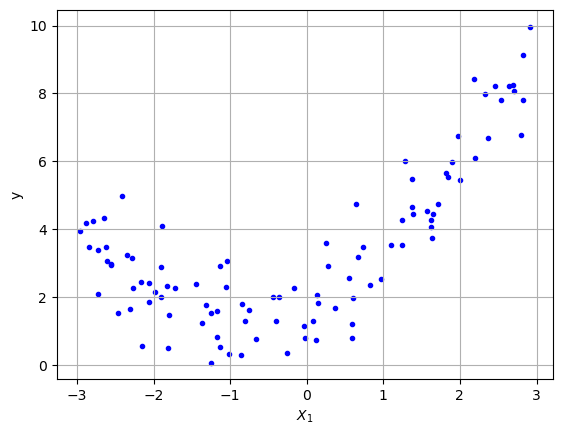

In [19]:
plt.scatter(X, y, marker = '.', color = 'blue')
plt.grid('True')
plt.xlabel(r'$X_1$')
plt.ylabel('y');

Vamos a usar scikit para transformar nuestros datos de entrenamiento, añadiendo el cuadrado de cada variable como nueva variable

In [20]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [21]:
X_poly[0] # ahora está X_1 y X_1^2

array([-0.75275929,  0.56664654])

In [22]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

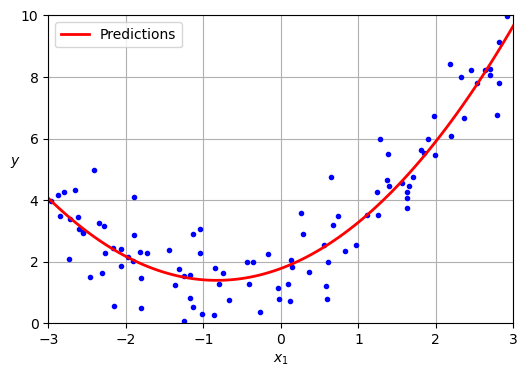

In [23]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper left")
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

El modelo estima:
   

$$
\hat{y} = 0.56x_1^2 + 0.93x_1 + 1.78
$$

### Curvas de aprendizaje

Al tener grados más altos de polinomia es más probable ajustar mejor los datos de entrenamiento, por ejemplo

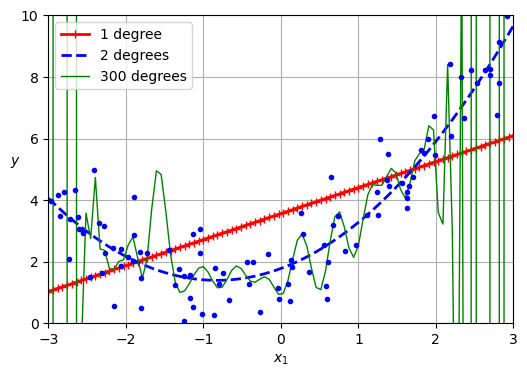

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

plt.figure(figsize=(6, 4))

for style, width, degree in (("r-+", 2, 1), ("b--", 2, 2), ("g-", 1, 300)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = make_pipeline(polybig_features, std_scaler, lin_reg)
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    label = f"{degree} degree{'s' if degree > 1 else ''}"
    plt.plot(X_new, y_newbig, style, label=label, linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

Este modelo de polinomio 300 está sobreajustando el modelo a los datos de entrenamiento mientras el modelo de un polinomio los subajusta, el mejor modelo en est caso es el cuadrático, nos damos cuenta de esto con la validación cruzada, otra forma de saber esto es con las curvas de aprendizaje, son gráficos del error de entrenamiento del modelo como función de la iteración de entrenamiento: evalua el modelo en intervalo regulares durante el entrenamiento en el conjunto de entrenamiento y validación y grafica los resultados.

Scikit tiene una función learning_curve() para ayudar con esto

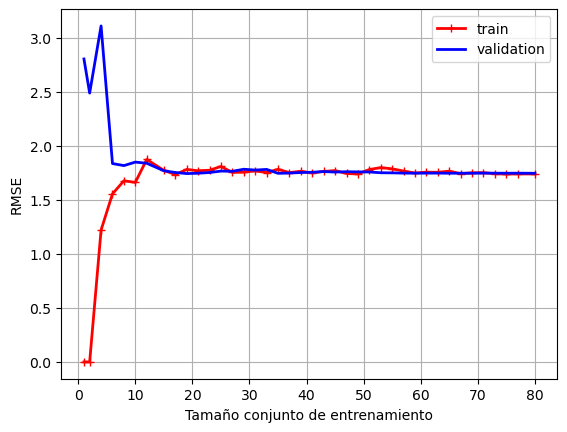

In [25]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes = np.linspace(0.01, 1.0, 40), cv = 5,
    scoring = 'neg_root_mean_squared_error')
train_errors = -train_scores.mean(axis = 1)
valid_errors = -valid_scores.mean(axis = 1)

plt.plot(train_sizes, train_errors, 'r-+', linewidth = 2, label = 'train')
plt.plot(train_sizes, valid_errors, 'b-', linewidth = 2, label = 'validation')
plt.grid('True')
plt.xlabel('Tamaño conjunto de entrenamiento')
plt.ylabel('RMSE')
plt.legend(loc = 'best');

Este modelo está subajustado, cuando hay solo 1 o 2 instancias en el entrenamiento las ajusta perfectamente, pero al añadir nuevas instancias se vuelve imposible para el modelo ajustarlas perfectamente ya que los datos tienen ruido y no son lineales hasta que converge en un punto donde añadir nuevas instancias no aumenta ni decrece el error considerablemente.

Ahora el error de validación, cuando se entrena en pocas instancias es imposible generalizarlo, por eso el error es tan grande, al introducir mas ejemplos el modelo aprende y el error de validación decrece, igualmente, un modelo lineal no puede modelar estos datos, por eso se estanca en un valor, si ambos errores se estancan en un valor cercano y alto el modelo subajusta los datos, ahora veamos un modelo de polinomio 10

In [26]:
polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

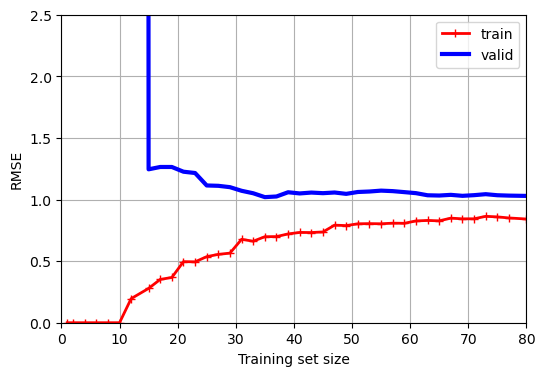

In [27]:
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, 80, 0, 2.5])
plt.show()

Hay dos diferencias importantes:

- Los errores en el conjunto de entrenamiento son mas pequeños.
- Hay un espacio entre las curvas, el modelo rinde mejor en los datos de entrenamiento que en los de validación, esta es una señal de sobreajuste, se puede mejorar agregando datos al modelo.

El error de generalización se puede expresar como la suma de tres errores:

- Sesgo: Esta parte se debe a supuestos erroneos, por ejemplo suponer que los datos son lineales si son cuadráticos, un modelo con mucho sesgo es muy probable que subajuste los datos de entrenamiento.

- Varianza: Esta parte se debe a mucha sensitividad a pequeñas variaciones en los datos de entrenamiento, un modelo con muchos grados tiende a tener varianza alta y por lo tanto sobreajustar el modelo.

- Error irreducible: Este error se debe al ruido de los datos, la forma de reducir este error es limpiar los datos (ejemplo: outliers)

### Modelos lineales regularizados 

Un metodo de reducir el sobreajuste es regularizando el modelo (poniendo restricciones), una forma sencilla de regularizar el modelo es reduciendo el numero de grado del polinomio.

Para un modelo lineal la regularización se consigue restringiendo los pesos del modelo, se van a ver tres modelos diferentes:

#### Regresión Ridge

Conocida también como la regularizacion Tikhonov, es una verisón regularizada de la regresión lineal, un termino regulador $\frac{\alpha}{m}\sum_{i=1}^n \beta_i^2$ es añadido al MSE, esto obliga al algoritmo a no solo ajustar los datos pero tambien a mantener los pesos del modelo tan pequeños como sea posible, este termino regulador solo se debe agregar a la función de costo durante el entrenamiento, una vez entrenado se usa el MSE sin regular para evaluar el rendimiento.

$\alpha$ es el hiperparámetro que controla cuanto se quiere regularizar el modelo, $\alpha = 0$ es una regresión lineal, si $\alpha$ es muy grande los pesos terminan cercanos a cero y el resultado es una linea plana a traves de al media de los datos, la función de costo de la regresión ridge:

$$
J(\beta) = MSE + \frac{\alpha}{m}\sum_{i=1}^n \beta_i^2
$$

El termino de sesgo $\beta_0$ no está regularizado, si defininmos 2 como el vector de los pesos de las variables, el termino de regularización es igual a $\alpha(|| w ||_2)^2 / m$, donde $|| w ||_2$ representa la norma del vector de pesos, para GD por lotes, solo agregaer $2\alpha2 / m$ a la parte del MSE vector gradiente que corresponde la los pesos de las variables, sin agregar nada al gradiente del termino del sesgo.

Es importante escalar los datos antes de hacer un regresión ridge, es sensible a la escala de las variables , esto es verdad para la mayoría de modelos regularizados

In [28]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.82899748]])

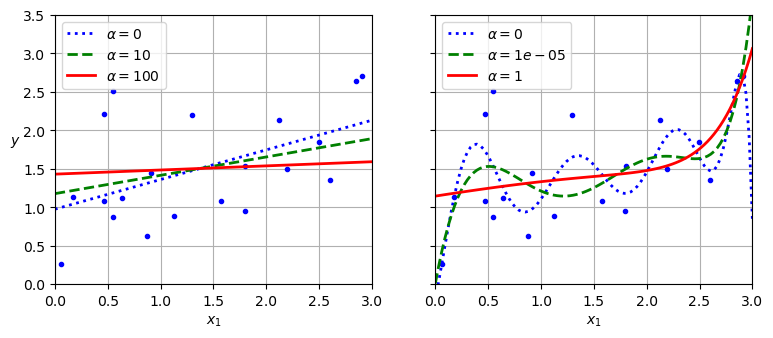

In [29]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(X, y, "b.", linewidth=3)
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kwargs)
        else:
            model = LinearRegression()
        if polynomial:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                model)
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth=2,
                 label=fr"$\alpha = {alpha}$")
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.axis([0, 3, 0, 3.5])
    plt.grid()

plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

Como en la regresión lineal pordemos usar una solución de forma cerrada, donde A es la matriz identidad $(n+1)\times(n+1)$

$$
\hat{\beta} = (X^TX + \alpha A)^{-1}X^Ty
$$

In [30]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha = 0.1, solver = 'cholesky') # variante de la formula pasada que usa factorizacion de cholesky
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55325833]])

In [31]:
# Ahora usando GD estocástico

sgd_reg = SGDRegressor(penalty = 'l2', alpha = 0.1 / m, tol = None,
                      max_iter = 1000, eta0 = 0.01, random_state = 42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.55302613])

Aquí especificamos la penalidad l2 indicando que queremos que el SGD agregue un termino de regularización al MSE igual al alpha por el cuadrado de la norma l2 del vector de pesos, lo mismo que en la regresión ridge, solo que no divide por m en este caso, por eso pasamos 0.1 / m.

La clase RidgeCV hace validación cruzada y es mucho más eficiente que GridSearchCV, también está LassoCV y ElasticNetCV.


### Regresión Lasso 

*Least absolute shrinkage and selection operator regression* Igual que la ridge agrega un termino regularizador a la función de costo, pero usa la norma $l_1$ del vector de pesos en vez de la $l_2$,

$$
J(\beta) = MSE(\beta) + 2\alpha \sum_{i=1}^n|\beta_i|
$$

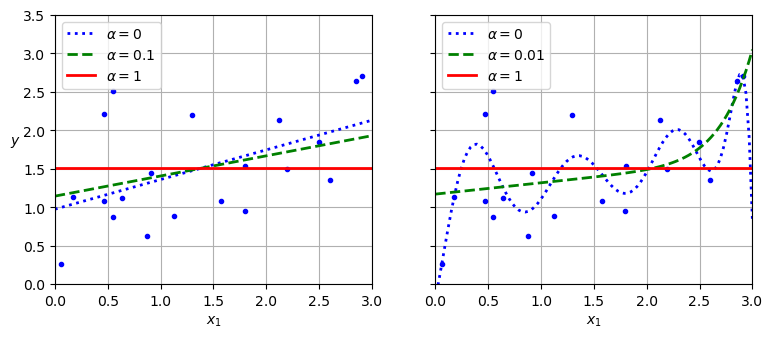

In [32]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 1e-2, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

La regresión LASSO tiende a eliminar los pesos de las variables menos importantes, por ejemplo la linea verde en la imagen de la izquierda se ve casi cúbica, los pesos para los polinomios de más grado son iguales a cero, la regresión lasso hace automaticamente selección de variables 

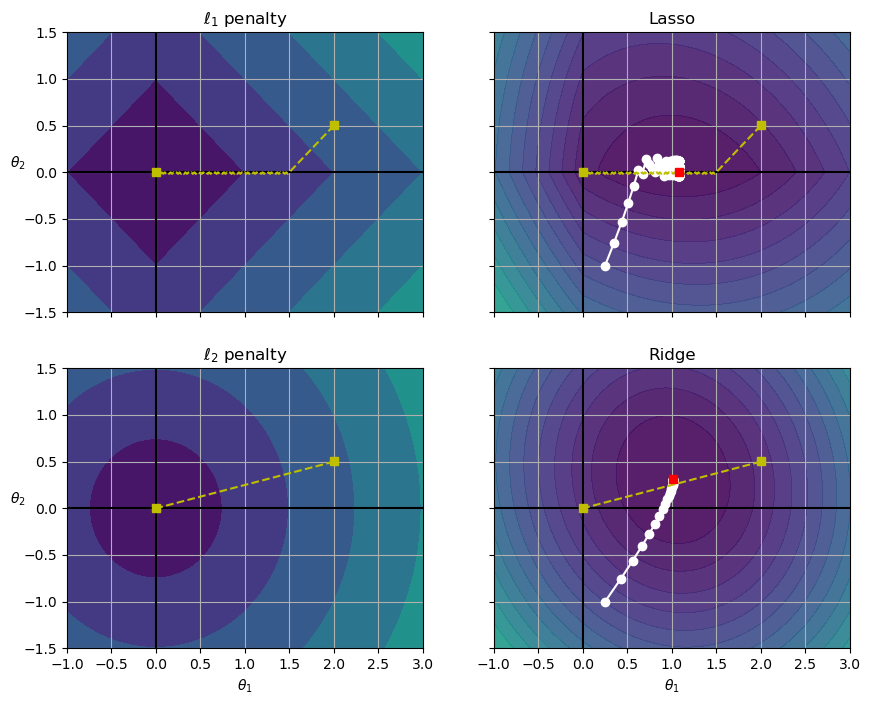

In [33]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1 / len(Xr) * ((T @ Xr.T - yr.T) ** 2).sum(axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(J.argmin(), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

def bgd_path(theta, X, y, l1, l2, core=1, eta=0.05, n_iterations=200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = (core * 2 / len(X) * X.T @ (X @ theta - y)
                     + l1 * np.sign(theta) + l2 * theta)
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))

for i, N, l1, l2, title in ((0, N1, 2.0, 0, "Lasso"), (1, N2, 0, 2.0, "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2 ** 2

    tr_min_idx = np.unravel_index(JR.argmin(), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levels = np.exp(np.linspace(0, 1, 20)) - 1
    levelsJ = levels * (J.max() - J.min()) + J.min()
    levelsJR = levels * (JR.max() - JR.min()) + JR.min()
    levelsN = np.linspace(0, N.max(), 10)

    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(theta=np.array([[2.0], [0.5]]), X=Xr, y=yr,
                      l1=np.sign(l1) / 3, l2=np.sign(l2), core=0)
    ax = axes[i, 0]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, N / 2.0, levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(fr"$\ell_{i + 1}$ penalty")
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")
    ax.set_ylabel(r"$\theta_2$", rotation=0)

    ax = axes[i, 1]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")

plt.show()

La función de costo Lasso no es diferenciable en $\beta_i = 0$, pero la descenso de gradiente todavía funciona usando un vector subgradiente $g^{11}$ cuando $\beta_i = 0$ 

$$
g(\beta, J) = \nabla_{\beta}MSE(\beta) + 2\alpha \begin{pmatrix} 
sign(\beta_1) \\
sign(\beta_2) \\
\vdots \\
sign(\beta_n)
\end{pmatrix}
$$

Así se usa en scikit learn,

In [34]:
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

También se podría usar SGDRegressor(penalty = 'l1', alpha = 0.1)

### Elastic net

La elastic net es un punto medio entre la regresión ridge y la regresión lasso, el termino de regularización es una suma con pesos de ambos terminos de regularización, con pesos r, cuando $r = 0$ tenemos una regresion ridge y si $r = 1$ tenemos una regresión lasso.

$$
J(\beta) = MSE(\beta) + r(2\alpha\sum_{i=1}^n|\beta_i|) + (1-r)\left(\frac{\alpha}{m}\sum_{i=1}^n\beta_i^2\right)
$$

Siempre es preferible usar una regularización así sea un poco, ridge es una buena opción por default pero si se sospecha que pocas variables son útiles se preferiría una regresión lasso o elastic net, elastic net es preferida por encima de lasso porque lasso se puede comportar raro cuando el numero de variables es más grande que el numero de instancias o cuando hay variables fuertemente correlacionadas, un ejemplo de elastic net:

In [35]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha = 0.1, l1_ratio = 0.5) # l1 ratio es el r que calcula el peso de cada una
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

### Early stopping

Otra forma de regularizar estos algoritmos es parar en el punto que el algoritmo encuentre un minimo esto se llama parada temprana

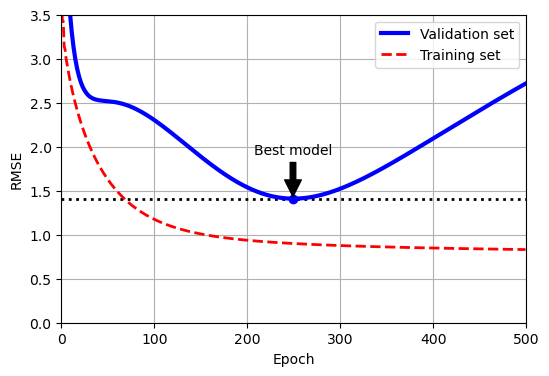

In [36]:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# extra code – creates the same quadratic dataset as earlier and splits it
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')
train_errors, val_errors = [], []  # extra code – it's for the figure below

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = mean_squared_error(y_valid, y_valid_predict, squared=False)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

    # extra code – we evaluate the train error and save it for the figure
    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = mean_squared_error(y_train, y_train_predict, squared=False)
    val_errors.append(val_error)
    train_errors.append(train_error)

# extra code – this section generates and saves Figure 4–20
best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))
plt.annotate('Best model',
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()
plt.show()

En este caso se muestra un modelo polinomico entrenado con descenso de gradiente, entre que van aumentando los epochs los dos errores van disminuyendo pero llega un momento que el error del conjunto de entrenamiento sigue disminuyendo y el error de validación sigue aumentando, en este caso parece que ha empezado a sobreajustar los datos de entrenamiento, con la parada temprana solo se para cuando el conjunto de validación llegue a un minimo para evitar esto, esta tecnica la llamaron *hermoso almuerzo gratis*

In [37]:
from copy import deepcopy 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

X_train, y_train, X_valid, y_valid = X[: m // 2], y[: m // 2, 0], X[m // 2 :], y[m // 2 :, 0]

preprocessing = make_pipeline(PolynomialFeatures(degree = 90, include_bias = False),
                             StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty = None, eta0 = 0.002, random_state = 42)
n_epochs = 500
best_valid_rmse = float('inf')

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = mean_squared_error(y_valid, y_valid_predict, squared = False)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

Aqui se llama partial_fit en vez de fit para ejecutar un aprendizaje incremental, en cada epoch mide el RMSE en el set de validación, si es mas bajo que el RMSE más bajo crea una copia del modelo en la variable best_model, esta implementación no se detiene pero deja acceder al mejor modelo después del entrenamiento.

## Regresión logistica

Esta regresión se usa para estimar la probabilidad de que una observación pertenezca a cierta clase, si la probabilidad estimada es mayor a cierto limite (por ejemplo 50%) el modelo predice que la observación pertenece a la clase.

### Estimar las probabilidades

Una regresión logistica computa una suma con pesos de las variables y devuelve los resultados logisticos

$$
\hat{p} = h_{\beta}(x) = \sigma(\beta^Tx)
$$

La función $\sigma(\cdot)$ es una función sigmoide que devuelve un número entre 0 y 1,

$$
\sigma(t) = \frac{1}{1+exp(-t)}
$$

Luego de que haya estimado la probabilidad, se puede escoger la clase,

$$
\hat{y} = \begin{cases}
      0, & \hat{p}< 0.5 \\
      1, & \hat{p} \geq 0.5
    \end{cases}
$$

### Entrenamiento y función de costo

La idea es entrenarlo para que estime altas probabilidades para observaciones positivas (y = 1) y bajas probabilidades para observaciones negativas (y = 0), esto se captura con la siguiente función de costo,

$$
c(\beta) = \begin{cases}
-log(\hat{p})\hspace{0.75cm}, \hspace{0.2cm} y = 1 \\
-log(1 - \hat{p}), \hspace{0.2cm} y = 0
\end{cases}
$$

$-log(t)$ crece a medida que t se acerca a 0, el costo va a ser grande si el modelo estima una probabilidad cerca a para una observación positiva, también va a ser muy grande si estima una probabilidad cerca a 1 para una observación negativa, por otra parte $-log(t)$ se acerca a 0 si t se acerca a 1, igualmente para el otro caso.

La función de costo para todo el conjunto de entrenamiento es el promedio de todas las observaciones, se puede escribir en esta formula,

$$
J(\beta) = -\frac{1}{m}\sum_{i=1}^n\left[y^{(i)}log(\hat{p}^{(i)}+(1-y^{(i)})log(1 - \hat{p}^{(i)})\right]
$$

Se puede demostrar con inferencia bayesiana que minimizando esta perdida resulta en el modelo con maxima versoimilitud, asumiendo que las observaciones tengan una distribución gaussiana sobre la media de su clase, si no se cumple este supuesto el modelo va a estar sesgado, igualmente cuando se usa el MSE para entrenar modelos de regresión asumimos que los datos son lineales, entre mas se viole este supuesto mas sesgado va a ser el modelo.

La mala noticia es que no hay una forma cerrada para computar el valor de $\beta$ que minimice la función de costo, pero la función es convexa, por lo tanto el descenso de gradiente o algun otro algoritmo funcionana para encontrar el minimo global.

$$
\frac{\delta}{\delta\beta_j}J(\beta) = \frac{1}{m}\sum_{i=1}^n(\sigma(\beta^Tx^{(i)})- y^{(i)})x_j^{(i)}
$$

Para cada observación computa el error de predicción y la multiplica por la j esima variable y computa el promedio de todas las observaciones de entrenamiento, una vez se tengan todas las derivadas parciales se pueden usar en el algoritmo de descenso de gradiente por lote.

### Limites de decisión

Vamos a usar un ejemplo para la regresión logistica con los datos de iris, contiene datos del tamaño de sepal y petalo de tres diferentes especies, Iris setosa, Iris versicolor e Iris virginica

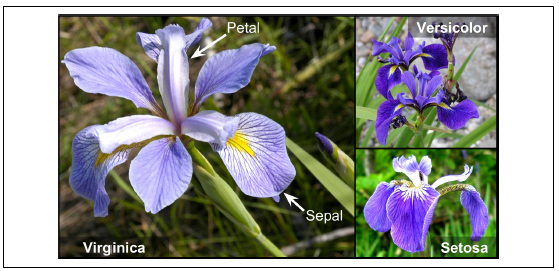

In [38]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame = True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [39]:
iris.data.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [40]:
iris.target.head(3) # las observaciones no están barajadas

0    0
1    0
2    0
Name: target, dtype: int32

In [41]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[['petal width (cm)']].values
y = iris.target_names[iris.target] == 'virginica'

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [44]:
log_reg = LogisticRegression(random_state = 42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

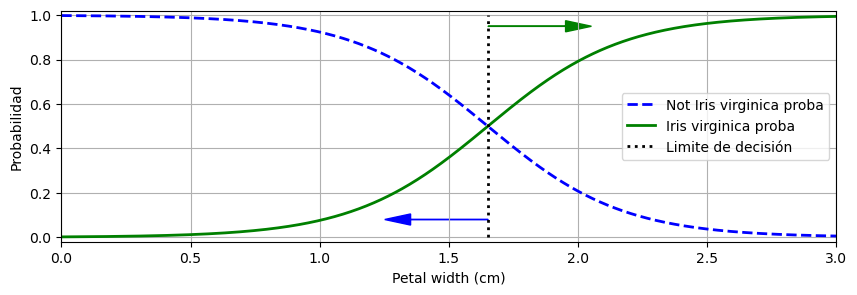

In [45]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1) # para tener un vector columna
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]

plt.figure(figsize=(10, 3))
plt.plot(X_new, y_proba[:, 0], 'b--', linewidth = 2, label = 'Not Iris virginica proba')
plt.plot(X_new, y_proba[:, 1], 'g-', linewidth = 2, label = 'Iris virginica proba')
plt.plot([decision_boundary, decision_boundary], [0, 1], 'k:', linewidth = 2, label = 'Limite de decisión')
plt.grid('True')
plt.xlabel('Petal width (cm)')
plt.ylabel('Probabilidad')
plt.legend(loc = 'best')
plt.axis([0, 3, -0.02, 1.02])
plt.arrow(x=decision_boundary, y=0.08, dx=-0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="b", ec="b")
plt.arrow(x = decision_boundary, y = 0.95, dx = 0.3, dy = 0,
         head_width = 0.05, head_length = 0.1, fc = 'g', ec = 'g');

Por encima de 2 cm el clasificador está seguro que la observación pertenece a iris virginica, vamos a ver el limite de decisión

In [46]:
decision_boundary

1.6516516516516517

In [47]:
log_reg.predict([[1.7], [1.5]])

array([ True, False])

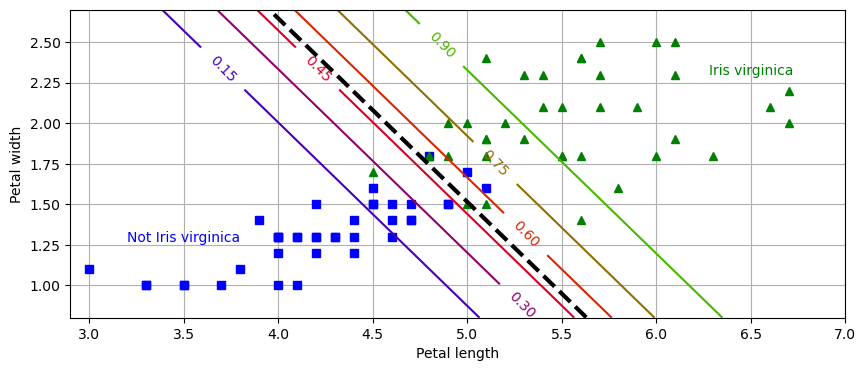

In [48]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(C=2, random_state=42)
log_reg.fit(X_train, y_train)

# for the contour plot
x0, x1 = np.meshgrid(np.linspace(2.9, 7, 500).reshape(-1, 1),
                     np.linspace(0.8, 2.7, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]  # one instance per point on the figure
y_proba = log_reg.predict_proba(X_new)
zz = y_proba[:, 1].reshape(x0.shape)

# for the decision boundary
left_right = np.array([2.9, 7])
boundary = -((log_reg.coef_[0, 0] * left_right + log_reg.intercept_[0])
             / log_reg.coef_[0, 1])

plt.figure(figsize=(10, 4))
plt.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], "bs")
plt.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], "g^")
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
plt.clabel(contour, inline=1)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.27, "Not Iris virginica", color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", color="g", ha="center")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([2.9, 7, 0.8, 2.7])
plt.grid()
plt.show()

este es un nuevo modelo en dos variables, la linea punteada representa el punto donde el modelo estima una probabilidad del 50% este es el limite de decisión, cada linea representa una probabilidad especifica del 15% al 90%.

El hyperparámetro que controla la regularización de una regresión logistica con es alpha, es su inversa C, entre más alto C el modelo tiene menos regularización.

La regresión logaritmica puede estar regularizado por penalidades $l_1,l_2$ scikit agrega una penalidad $l_2$ por default.


### Regresión softmax

El modelo logistico puede ser generalizado para soportar multiples clases sin tener que entrenar y combinar multiples clasificadores binarios, a esto se le llama la regresión softmax o regresión logistica multinomial.

Dada una instancia x, la regresión softmax computa un puntaje $s_k(x)$ para cade clase k, estima la probabilidad de cada clase aplicando la función softmax a los puntajes,

$$
s_k(x) = (\beta^{(k)})^Tx
$$

Una vez calculado el puntaje de cada clase para la instancia x, se puede estimar la probabilidad $\hat{p}_k$ que la instancia pertenezca a la clase k corriendo los puntajes por la función softmax,

$$
\hat{p}_k = \sigma(s(x))_k = \frac{exp(s_k(x))}{\sum_{i=1}^k exp(s_j(x))}
$$

La función devuelve el valor de k que maximiza la probabilidad estimada.

El objetivo es tener un modelo que estime probabilidades altas para la clase target, para eso tenemos la función de coste entropia cruzada, penaliza el modelo cuando estima una probabilidad baja para la clase target

$$
J(\beta) = -\frac{1}{m}\sum_{k=1}^Ky_k^{(i)}log(\hat{p}_k^{(i)})
$$

$y_k^{(i)}$ es la probabilidad target de que la observación i pertenezca a la clase k, en general es 1 o 0. El vector gradiente de esta función de costo con respecto a $\beta^{(k)}$ está dada por,

$$
\nabla_{\beta}^{(k)}J(\beta) = \frac{1}{m}\sum_{i=1}^m (\hat{p}_k^{(i)}-y_k^{(i)})x^{(i)}
$$

Ahora se puede computar el vector gradiente para cada clase y usar el descenso de gradiente para encontrar la matriz de parametros $\beta$ que minimiza la función de costo.

Ahora se usa la regresión softmax para clasificar las plantas iris en tres clases, scikit Logistic Regression usa regresion softmax automaticamente cuando entrenas mas de dos clases (usando solver = 'lbfgs'), también aplica la regularización $l_2$ que se puede controlar usando el hiperparámetros C.

In [49]:
X = iris.data[['petal length (cm)', 'petal width (cm)']].values
y = iris['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

softmax_reg = LogisticRegression(C = 30, random_state = 42)
softmax_reg.fit(X_train, y_train)

LogisticRegression(C=30, random_state=42)

Por ejemplo, un iris con petalos de 5 cm de largo y 2 cm de ancho, se puede preguntar al modelo que tipo de iris es

In [50]:
softmax_reg.predict([[5, 2]])

array([2])

In [51]:
softmax_reg.predict_proba([[5, 2]]).round(2)

array([[0.  , 0.04, 0.96]])

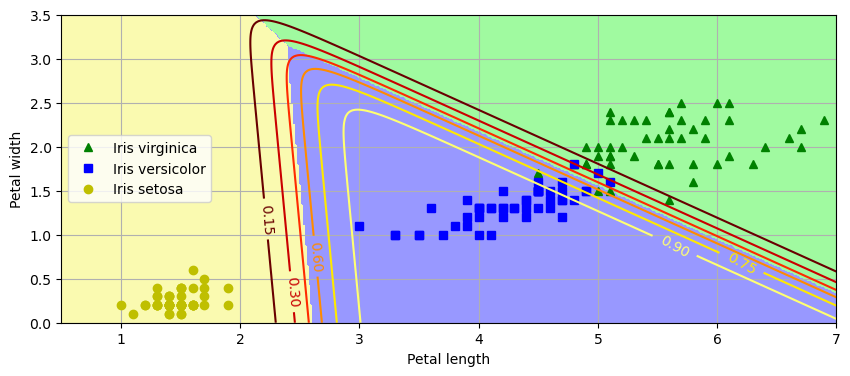

In [52]:
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="center left")
plt.axis([0.5, 7, 0, 3.5])
plt.grid()
plt.show()

## Ejercicios

1. Which linear regression training algorithm can you use if you have a training set with millions of features?

Se podría usar descenso de gradiente estocástico o por mini lotes, de pronto de lote, pero no se puede usar la ecuación normal o SVD ya que la complejidad computacional crece rapidamente con el numero de variables.

2. Suppose the features in your training set have very different scales. Which algorithms might suffer from this, and how? What can you do about it?

Los algoritmos de descenso de gradiente se ven afectados por las diferentes escalas en las variables, para esto se puede escalar o estandarizar todas las variables ya que la función de costo va a tener el forma de un plato estirado, el algoritmo GD va a demorarse en converger, los modelos regularizados pueden converger a una solución subóptima si las variables no están escaladas.

3. Can gradient descent get stuck in a local minimum when training a logistic regression model?

No porque la función de costo es convexa.

4. Do all gradient descent algorithms lead to the same model, provided you let them run long enough?

No, porque el GD estocástico y el mini lote al ser aleatorios, puede que ronde cerca al minimo encontrado por los otros modelos pero nunca se va a establecer en un minimo concreto, a menos que se disminuya la tasa de aprendizaje. Si la función de costo es convexa y la tasa de aprendizaje no es muy alta si, los tres modelos van a acercarse al mismo modelo.

5. Suppose you use batch gradient descent and you plot the validation error at every epoch. If you notice that the validation error consistently goes up, what is likely going on? How can you fix this?

Lo primero que pienso es que el modelo está sobreajustando los datos, esto es si el error de entrenamiento no está aumentando. Si el error de entrenamiento está aumentando también una posibilidad es que la tasa de aprendizaje sea muy alta y el algoritmo está divirgiendo.

6. Is it a good idea to stop mini-batch gradient descent immediately when the validation error goes up?

No, ya que al ser aleatorio puede incrementar y volver a descender, en este caso una parada temprana no sería lo óptimo, lo mejor es guardar el modelo cada tanto tiempo, si no ha mejorado en un intervalo de tiempo se puede revertir al modelo anterior.

7. Which gradient descent algorithm (among those we discussed) will reach the vicinity of the optimal solution the fastest? Which will actually converge? How can you make the others converge as well?

Creo que el que más rápido va a acercarse al minimo es el estocástico, al depender de una sola observación es el más eficiente, el único que realmente converge es el de lote completo al no depender de la aleatoriedad, los otros se podrían hacer converger disminuyendo la tasa de aprendizaje progresivamente.

8. Suppose you are using polynomial regression. You plot the learning curves and you notice that there is a large gap between the training error and the validation error. What is happening? What are three ways to solve this?

Primero sobre ajuste del modelo, tal vez se escogió un polinomia muy grande, se puede tratar de regularizar el modelo añadiendo una penalidad a la función de costo, por ultimo, tratar de agregar más datos al entrenamiento.

9. Suppose you are using ridge regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter α or reduce it?

Si el error de entrenamiento es alto es más probable que se esté subajustando y que se sufra de alto sesgo, si el error de entrenamiento fuera bajo podriamos decir que se sobreajusta y hay harta varianza, por lo tanto alto sesgo, en este caso se debería reducir el parámetro de regularización.

10. Why would you want to use:

- Ridge regression instead of plain linear regression (i.e., without any regularization)?

Un modelo con algo de regularización tipicamente rinde mejor que un modelo sin regularización.

- Lasso instead of ridge regression?

Al usar lasso la penzalización es posible que establezca algunos pesos de variables no importantes al modelo, por lo tanto es mejor usar lasso sobre ridge ya que haría parte de un feature selection incluido.

- Elastic net instead of lasso regression?

la regresión lasso se comporta raro si hay variables con lata correlación o cuando hay mas variables que observaciones, pero añade otro hiperparámetro para ajustar, si se quiere lasso sin este comportamiento raro se puede usar elastic net con un l1_ratio cercano a 1.

11. Suppose you want to classify pictures as outdoor/indoor and daytime/nighttime. Should you implement two logistic regression classifiers or one softmax regression classifier?  

Ya que estas no son clases exclusivas (las 4 combinaciones son posibles) se debería entrenar dos modelos logisticos separados.

12. Implement batch gradient descent with early stopping for softmax regression without using Scikit-Learn, only NumPy. Use it on a classification task such as the iris dataset.

In [83]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"].values

Hay que añadir el intercepto o termino de sesgo

In [84]:
X_with_bias = np.c_[np.ones(len(X)), X] # aqui se usaría add_dummy_feature()

Ahora se parten los datos en entrenamiento y prueba

In [93]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

np.random.seed(42)
rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

La target son indices de clases 0, 1 y 2, pero necesitamos las probabilidades de la clase de target, cada instancia va a tener probabilidad de clase target igual a 0 para todas las clases excepto para la clase target que va a tener una probabilidad de 1.

In [94]:
def to_one_hot(y):
    return np.diag(np.ones(y.max() + 1))[y]

In [95]:
y_train[:10]

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1])

In [96]:
to_one_hot(y_train[:10])

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [97]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

In [98]:
mean = X_train[:, 1:].mean(axis=0)
std = X_train[:, 1:].std(axis=0)
X_train[:, 1:] = (X_train[:, 1:] - mean) / std
X_valid[:, 1:] = (X_valid[:, 1:] - mean) / std
X_test[:, 1:] = (X_test[:, 1:] - mean) / std

Ahora aplicamos la función softmax

$$
\sigma(s(x))_k = \frac{\exp(s_k(x))}{\sum_{j=1}^K\exp(s_j(x))}
$$

In [99]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = exps.sum(axis=1, keepdims=True)
    return exps / exp_sums

Ahora definir el numero de inputs y outputs

In [100]:
n_inputs = X_train.shape[1] # 3 (2 variables y el intercepto)
n_outputs = len(np.unique(y_train)) # 3 (3 clases de iris)

Ahora viene la parte de entrenamiento, necesitamos dos ecuaciones, la primera es la función costo:

$$
J(\mathbf{\Theta}) = \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}
$$

Y la ecuación para los gradientes:

$$
\nabla_{\beta}^{(k)}J(\beta) = \frac{1}{m}\sum_{i=1}^m (\hat{p}_k^{(i)}-y_k^{(i)})x^{(i)}
$$

El $\log\left(\hat{p}_k^{(i)}\right)$ puede no ser computable si $\hat{p}_k^{(i)} = 0$ así que se añade un valor $\epsilon$ para evitar tener nan.

In [101]:
eta = 0.5
n_epochs = 5001
m = len(X_train)
epsilon = 1e-5

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    if epoch % 1000 == 0:
        Y_proba_valid = softmax(X_valid @ Theta)
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
        print(epoch, xentropy_losses.sum(axis=1).mean())
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    Theta = Theta - eta * gradients

0 3.7085808486476917
1000 0.14519367480830644
2000 0.13013095755040874
3000 0.12009639326384534
4000 0.11372961364786885
5000 0.11002459532472428


In [102]:
Theta

array([[ 0.41931626,  6.11112089, -5.52429876],
       [-6.53054533, -0.74608616,  8.33137102],
       [-5.28115784,  0.25152675,  6.90680425]])

In [103]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

Ahora se va a agregar una regularización $l_2$, la perdida y los gradientes tienen un termino adicional, también se incrementa la tasa de aprendizaje

In [104]:
eta = 0.5
n_epochs = 5001
m = len(X_train)
epsilon = 1e-5
alpha = 0.01  # regularization hyperparameter

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    if epoch % 1000 == 0:
        Y_proba_valid = softmax(X_valid @ Theta)
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
        l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
        total_loss = xentropy_losses.sum(axis=1).mean() + alpha * l2_loss
        print(epoch, total_loss.round(4))
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 3.7372
1000 0.3259
2000 0.3259
3000 0.3259
4000 0.3259
5000 0.3259


In [105]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

En este caso agregar la penalización no mejoró el modelo, de pronto se puede ajustar alpha?

Ahora vamos a crear una parada temprana, se mide la perdida en el conjunto de validación en cada iteración y se para cuando el error empiece a crecer

In [106]:
eta = 0.5
n_epochs = 50_001
m = len(X_train)
epsilon = 1e-5
C = 100  # regularization hyperparameter
best_loss = np.infty

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    Y_proba_valid = softmax(X_valid @ Theta)
    xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
    l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
    total_loss = xentropy_losses.sum(axis=1).mean() + 1 / C * l2_loss
    if epoch % 1000 == 0:
        print(epoch, total_loss.round(4))
    if total_loss < best_loss:
        best_loss = total_loss
    else:
        print(epoch - 1, best_loss.round(4))
        print(epoch, total_loss.round(4), "early stopping!")
        break
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), 1 / C * Theta[1:]]
    Theta = Theta - eta * gradients

0 3.7372
281 0.3256
282 0.3256 early stopping!


In [107]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

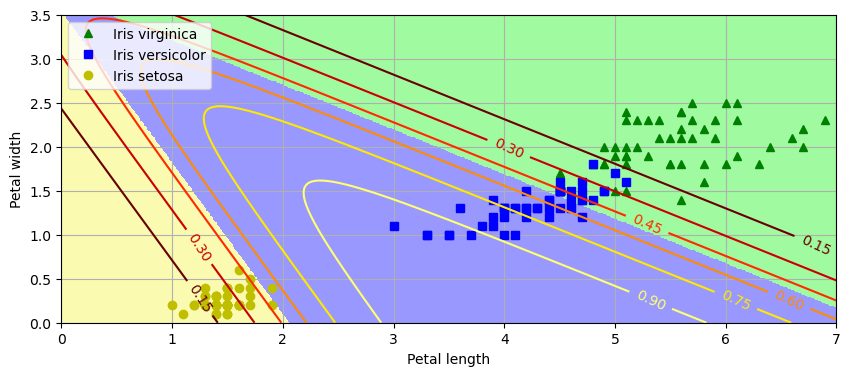

In [111]:
custom_cmap = mpl.colors.ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]

mean = X_new[:, 1:].mean(axis=0)
std = X_new[:, 1:].std(axis=0)

X_new = (X_new - mean / std)
X_new_with_bias = np.c_[np.ones(len(X_new)), X_new]

logits = X_new_with_bias @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 7, 0, 3.5])
plt.grid()
plt.show()

In [109]:
logits = X_test @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_test).mean()
accuracy_score

0.9666666666666667